<a href="https://colab.research.google.com/github/jl0274/windturbinemodels/blob/main/turbinepowermodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [ ]:
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
# can change directory to where you want your drive to be mounted
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks/COS IW: Wind Turbines')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


Note: dataset should be uploaded to Google Drive first before running this block

In [ ]:
import pandas as pd

# read in certain range data that yields a relatively balanced spred of power values
rows_skip = range(1, 6975000)
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/COS IW: Wind Turbines/longdata_20220706_20231231.csv',
                 skiprows=rows_skip,
                 nrows=100000)

# select relevant columns - reduce from 68 to 16 vars
relevant_df = df[['Time', 'XTurbSpeed1', 'GTEMP1', 'AIRTN', 'YP', 'WDNA',
                  'AIRHNA', 'BRDTEMP', 'PAB1', 'PAB2', 'PAB3', 'RST2', 'WD30',
                  'WS30', 'WDN', 'WSN', 'MaxPwrEst']]

In [ ]:
relevant_df.shape

(100000, 17)

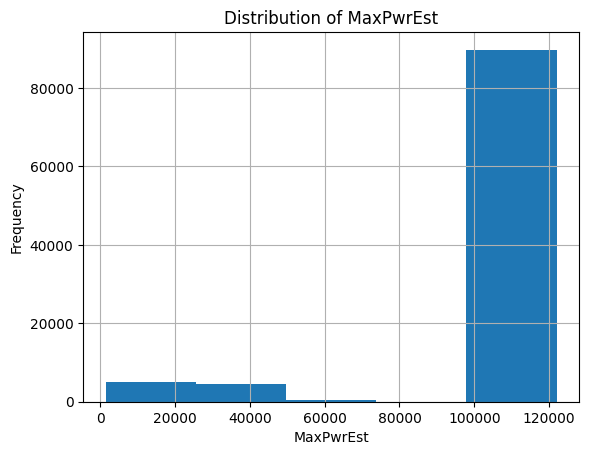

In [ ]:
import matplotlib.pyplot as plt
# visualize distribution of MaxPwrEst
# Plot the distribution of 'MaxPwrEst' using a histogram
df['MaxPwrEst'].hist(bins=5)

# Add labels and title
plt.xlabel('MaxPwrEst')
plt.ylabel('Frequency')
plt.title('Distribution of MaxPwrEst')

# Show the plot
plt.show()

In [ ]:
# Count the number of rows where 'MaxPwrEst' equals 122020
count_122020 = len(df[df['MaxPwrEst'] == 122020])

# Print the count
print("Number of rows where MaxPwrEst = 122020:", count_122020)
# print percentage
print('Percentage of rows where MaxPwrEst = 122020:', count_122020 / len(df) * 100, '%')

Number of rows where MaxPwrEst = 122020: 89752
Percentage of rows where MaxPwrEst = 122020: 89.752 %


Save data locally (optional)

In [ ]:
# # Download the CSV file
# from google.colab import files

# # Save DataFrame to a CSV file
# relevant_df.to_csv('dataset.csv', index=False)
# files.download('dataset.csv')

Inspect Data Visually

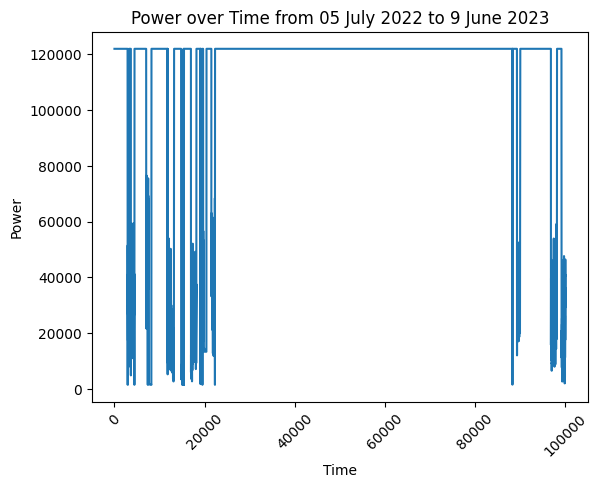

In [ ]:
import matplotlib.pyplot as plt

# Plotting the 'power' column
plt.plot(relevant_df['MaxPwrEst'])

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Power over Time from 05 July 2022 to 9 June 2023')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
relevant_df.head()
relevant_df.shape

(100000, 17)

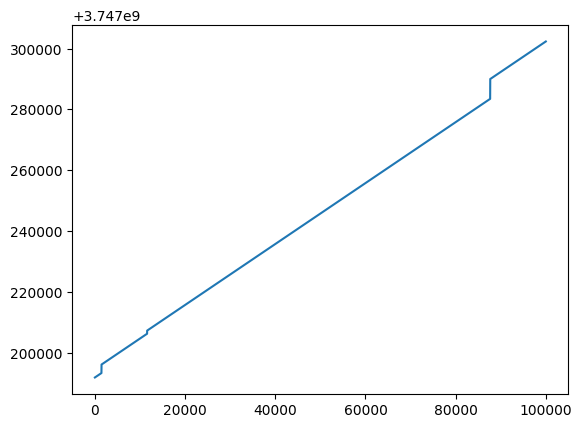

In [ ]:
# plot time to see if all time is taken consecutively
plt.plot(relevant_df['Time'])

Load libraries and X and y

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

!pip install -q -U keras-tuner

# define independent and dependent vars
# NOTE: KEEP TIME IN X FOR NOW, DROP LATER
X = relevant_df.drop(['MaxPwrEst'], axis=1).astype('float64')
print('X data types:')
print(X.dtypes)
y = relevant_df['MaxPwrEst'].astype('float64')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00
X data types:
Time           float64
XTurbSpeed1    float64
GTEMP1         float64
AIRTN          float64
YP             float64
WDNA           float64
AIRHNA         float64
BRDTEMP        float64
PAB1           float64
PAB2           float64
PAB3           float64
RST2           float64
WD30           float64
WS30           float64
WDN            float64
WSN            float64
dtype: object


Visualize modified function for power using modifications of the form a * f(T, ω) + b

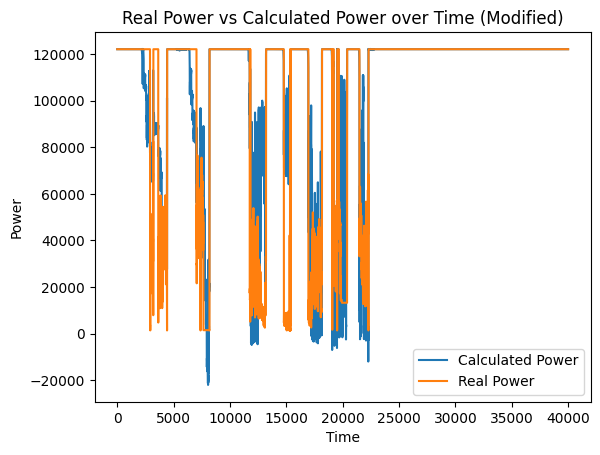

In [ ]:
real_power = y
calc_power = -0.4 * (X['RST2'] * X['XTurbSpeed1']) + 122020
# calc_power = (X['RST2'] * X['XTurbSpeed1'])

# Plot both real_power and calc_power on the same graph
plt.plot(calc_power[:40000], label='Calculated Power')
plt.plot(real_power[:40000], label='Real Power')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Real Power vs Calculated Power over Time (Modified)')

# Add legend
plt.legend()

# Show plot
plt.show()

# CONTROL NN

Constants

In [ ]:
NUM_FEATURES = 15

Split and normalize data

In [ ]:
# Split data into training and test sets
c_X = X.drop(['Time'], axis=1)
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, y,
                                                  test_size=0.3,
                                                  random_state=42)

# normalize data

c_X_train=(c_X_train-c_X_train.mean())/c_X_train.std()
c_X_test=(c_X_test-c_X_test.mean())/c_X_test.std()

c_X_train.fillna(0, inplace=True)
c_X_test.fillna(0, inplace=True)

print()
print("Normalized dataset")

c_X_train.shape


Normalized dataset


(70000, 15)

In [ ]:
c_X_train.head()

,XTurbSpeed1,GTEMP1,AIRTN,YP,WDNA,AIRHNA,BRDTEMP,PAB1,PAB2,PAB3,RST2,WD30,WS30,WDN,WSN
76513,-0.364013,-1.162326,-1.185477,0.009211,-0.843326,1.343489,-1.154666,0.37263,0.372628,0.372633,-0.006118,-0.585151,-0.791780,0.0,0.0
60406,-0.364013,-0.799529,-0.870354,0.005473,-0.842707,0.662194,-0.629193,0.37263,0.372628,0.372633,-0.679928,-0.778587,1.724994,0.0,0.0
27322,-0.363990,1.097504,1.748129,0.033507,0.625852,-1.338051,1.888861,0.37263,0.372628,0.372633,-0.102096,0.317550,2.489505,0.0,0.0
53699,-0.364013,-0.518077,-0.534674,0.006719,-0.842088,0.114735,-0.251389,0.37263,0.372628,0.372633,-0.068472,-0.520673,1.199804,0.0,0.0
65412,-0.364013,-1.004452,-1.046271,0.004850,-0.845183,1.152159,-0.910148,0.37263,0.372628,0.372633,-0.049814,-1.100981,0.757836,0.0,0.0


Run control linear regression to make sure MAPE is reasonable with control NN

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# split and normalize data
lin_X = X.drop(['Time'], axis=1)
lin_X_train, lin_X_test, lin_y_train, lin_y_test = train_test_split(lin_X, y,
                                                  test_size=0.3,
                                                  random_state=42)

# normalize data

lin_X_train=(lin_X_train-lin_X_train.mean())/lin_X_train.std()
lin_X_test=(lin_X_test-lin_X_test.mean())/lin_X_test.std()

lin_X_train.fillna(0, inplace=True)
lin_X_test.fillna(0, inplace=True)

print()
print("Normalized dataset")

lin_X_train.shape
lin_X_train_dropped = lin_X_train.dropna()
lin_X_train.head()




Normalized dataset


,XTurbSpeed1,GTEMP1,AIRTN,YP,WDNA,AIRHNA,BRDTEMP,PAB1,PAB2,PAB3,RST2,WD30,WS30,WDN,WSN
76513,-0.364013,-1.162326,-1.185477,0.009211,-0.843326,1.343489,-1.154666,0.37263,0.372628,0.372633,-0.006118,-0.585151,-0.791780,0.0,0.0
60406,-0.364013,-0.799529,-0.870354,0.005473,-0.842707,0.662194,-0.629193,0.37263,0.372628,0.372633,-0.679928,-0.778587,1.724994,0.0,0.0
27322,-0.363990,1.097504,1.748129,0.033507,0.625852,-1.338051,1.888861,0.37263,0.372628,0.372633,-0.102096,0.317550,2.489505,0.0,0.0
53699,-0.364013,-0.518077,-0.534674,0.006719,-0.842088,0.114735,-0.251389,0.37263,0.372628,0.372633,-0.068472,-0.520673,1.199804,0.0,0.0
65412,-0.364013,-1.004452,-1.046271,0.004850,-0.845183,1.152159,-0.910148,0.37263,0.372628,0.372633,-0.049814,-1.100981,0.757836,0.0,0.0


In [ ]:
# Assuming X_train and y_train are your training features and target
# Create and fit the linear regression model
linModel = LinearRegression()
linModel.fit(lin_X_train, lin_y_train)

# Make predictions
lin_y_pred = linModel.predict(lin_X_test)

# Calculate and print the mean squared error
mse = mean_squared_error(lin_y_test, lin_y_pred)
print("Mean Squared Error:", mse)

# You can also access the coefficients and intercept
print("Coefficients:", linModel.coef_)
print("Intercept:", linModel.intercept_)

# Assuming y_test and y_pred are the true labels and predicted labels, respectively
mape = mean_absolute_percentage_error(lin_y_test, lin_y_pred) * 100

print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error: 102567598.62036149
Coefficients: [-3.37183195e+04 -1.83224790e+03  3.79168469e+03 -2.18016169e+03
  3.94320883e+02  6.15058300e+03  2.14043666e+03 -3.83248242e+06
  3.06481564e+06  7.64719188e+05  4.38485407e+03  6.21016660e+02
  1.52032294e+03  0.00000000e+00  0.00000000e+00]
Intercept: 112083.29065857054
Mean Absolute Percentage Error (MAPE): 32.153257809948556


Optimize hyperparams for control NN - use this for future networks

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Define the hypermodel to optimize hyperparameters

def build_model(hp):

  input = tf.keras.Input(shape=(15,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')

  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss='mean_absolute_error')

  return model

# Step 2: Define the hyperparameter search space
tuner = kt.Hyperband(build_model,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='Power')

# Step 3: Search for the best hyperparameters
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Optimize hyperparameters based on a subset of the training set

Note: optimizing hyperparameters is computationally expensive, so once you find the optimized hyperparameters the first time, you can construct the model manually using those hyperparameters rather than rerunning the tuner and constructing the model based on what the tuner returns

In [ ]:
# Reset index to ensure integer-based indexing
c_X_train.reset_index(drop=True, inplace=True)
c_y_train.reset_index(drop=True, inplace=True)

# Calculate the subset size
subset_size = int(len(c_X_train) * 0.1)  # Adjust the percentage as needed

# Randomly sample the indices
subset_indices = c_X_train.sample(n=subset_size, replace=False).index

# Extract the subset from c_X_train and c_y_train
subset_X_train = c_X_train.loc[subset_indices]
subset_y_train = c_y_train.loc[subset_indices]

In [ ]:
tuner.search(subset_X_train, subset_y_train,
             epochs=10,
             validation_split=0.2, batch_size=128, callbacks=[stop_early])

# Step 4: Retrieve the best hyperparameters
c_best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 00m 04s]
val_loss: 111071.8828125

Best val_loss So Far: 22184.56640625
Total elapsed time: 00h 00m 21s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
16                |8                 |units
2                 |4                 |layers
tanh              |relu              |activation
0.01              |0.01              |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7b4bed651090>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Epoch 1/3


KeyboardInterrupt: 

In [ ]:
# view best hyperparams
best_units = c_best_hp.get('units')
best_layers = c_best_hp.get('layers')
best_activation = c_best_hp.get('activation')
best_learning_rate = c_best_hp.get('learning_rate')

print('Best Hyperparameters:')
print('units:', best_units)
print('best layers:', best_layers)
print('best activation function:', best_activation)
print('best learning rate:', best_learning_rate)

Run Control NN

In [ ]:
from keras.optimizers import Adam

# Build the model with the optimal hyperparameters and train it on the data for 75 epochs
optimizer = Adam(best_learning_rate)
c_model = tuner.hypermodel.build(c_best_hp)

# THIS COMMENTED OUT BLOCK IS AN EXAMPLE OF CONSTRUCTING THE MODEL MANUALLY RATHER THAN USING
# HYPERPARAMS c_best_hp LOADED FROM TUNER:
# optimizer = Adam(0.001)
# c_model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(NUM_FEATURES,)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)  # Output layer with 1 unit for regression
# ])

# Compile the model
c_model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using Adam optimizer and mean squared error loss for regression

# Print model summary
c_model.summary()

# Train the model

summary = c_model.fit(c_X_train, c_y_train, epochs=75, batch_size=32)

# test model
c_y_pred = c_model.predict(c_X_test)
c_y_train_pred = c_model.predict(c_X_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1024      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13569 (53.00 KB)
Trainable params: 13569 (53.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/75
2188/21

Get metrics on control NN

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

# print training history
print(summary.history)

# get accuracy metrics
print('training set error from most recent epoch:', summary.history['loss'][-1])
print('test set error:', mean_squared_error(c_y_test, c_y_pred))

# Get MAPE
train_mape = mean_absolute_percentage_error(c_y_train, c_y_train_pred) * 100
test_mape = mean_absolute_percentage_error(c_y_test, c_y_pred) * 100
print("TRAIN Mean Absolute Percentage Error (MAPE):", train_mape)
print("TEST Mean Absolute Percentage Error (MAPE):", test_mape)

# get MAE
train_mae = mean_absolute_error(c_y_train, c_y_train_pred)
test_mae = mean_absolute_error(c_y_test, c_y_pred)
print("TRAIN MAE:", train_mae)
print("TEST MAE:", test_mae)

# Calculate R-squared
r_squared = r2_score(c_y_test, c_y_pred)

print("Coefficient of determination (R-squared):", r_squared)

{'loss': [1173236096.0, 86581496.0, 52010036.0, 44355432.0, 39366208.0, 36105272.0, 33552800.0, 31586106.0, 29772860.0, 28460024.0, 27030500.0, 25880320.0, 25216278.0, 24419488.0, 23581404.0, 22778450.0, 22334564.0, 21759622.0, 21409534.0, 20977318.0, 20591358.0, 20070986.0, 19711862.0, 19521778.0, 19266046.0, 19000144.0, 18575964.0, 18617230.0, 17959816.0, 17976056.0, 17787388.0, 17569120.0, 17328236.0, 17475730.0, 17073044.0, 16799454.0, 16918628.0, 17050382.0, 16552778.0, 16498900.0, 16478913.0, 16275117.0, 15877102.0, 16070813.0, 16279601.0, 15884546.0, 16086652.0, 15673809.0, 15585887.0, 15515686.0, 15540434.0, 15415099.0, 15366573.0, 15464442.0, 14949239.0, 15002053.0, 14721473.0, 15005562.0, 14870475.0, 14964309.0, 14551336.0, 14517077.0, 14425480.0, 14670618.0, 14521313.0, 14577395.0, 14603887.0, 14464220.0, 14432376.0, 14155481.0, 14284678.0, 14310216.0, 14056672.0, 14302675.0, 14019824.0]}
training set error from most recent epoch: 14019824.0
test set error: 14048948.08141988

Graph loss over epochs

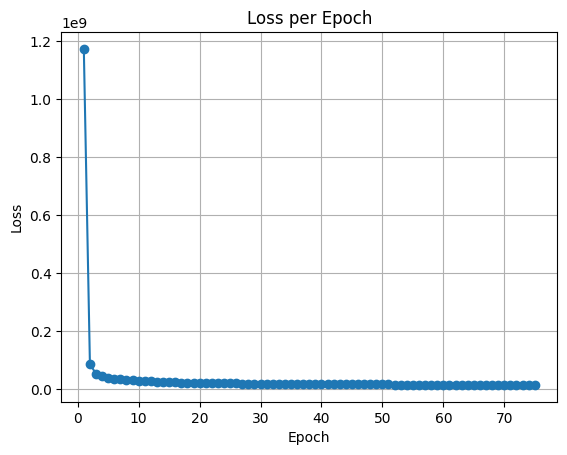

In [ ]:
losses = summary.history['loss']
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

# PINN

Split and normalize data

In [ ]:
# Split data into training and testing sets
p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(c_X, y, test_size=0.3, random_state=42)

# normalize data

p_X_train=(p_X_train-p_X_train.mean())/p_X_train.std()
p_X_test=(p_X_test-p_X_test.mean())/p_X_test.std()
# fill in NaN values from normalizing with 0
p_X_train.fillna(0, inplace=True)
p_X_test.fillna(0, inplace=True)

In [ ]:
p_X_train.head()

,XTurbSpeed1,GTEMP1,AIRTN,YP,WDNA,AIRHNA,BRDTEMP,PAB1,PAB2,PAB3,RST2,WD30,WS30,WDN,WSN
76513,-0.364013,-1.162326,-1.185477,0.009211,-0.843326,1.343489,-1.154666,0.37263,0.372628,0.372633,-0.006118,-0.585151,-0.791780,0.0,0.0
60406,-0.364013,-0.799529,-0.870354,0.005473,-0.842707,0.662194,-0.629193,0.37263,0.372628,0.372633,-0.679928,-0.778587,1.724994,0.0,0.0
27322,-0.363990,1.097504,1.748129,0.033507,0.625852,-1.338051,1.888861,0.37263,0.372628,0.372633,-0.102096,0.317550,2.489505,0.0,0.0
53699,-0.364013,-0.518077,-0.534674,0.006719,-0.842088,0.114735,-0.251389,0.37263,0.372628,0.372633,-0.068472,-0.520673,1.199804,0.0,0.0
65412,-0.364013,-1.004452,-1.046271,0.004850,-0.845183,1.152159,-0.910148,0.37263,0.372628,0.372633,-0.049814,-1.100981,0.757836,0.0,0.0


Define Custom Loss Function

In [ ]:
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self, x, name="custom_loss"):
    super().__init__(name=name)
    self.x = x

  def call(self, y_true, y_pred):
    # Mean Absolute Error loss for NN prediction
    mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Split the input layer into torque and angular velocity
    torque = self.x.iloc[:, 10].values.astype('float32')  # Assuming torque is the 11th variable
    angular_velocity = self.x.iloc[:, 0].values.astype('float32')  # Assuming angular velocity is the 1st variable

    # Calculate power using the physics equation
    predicted_power = -0.4 * (torque * angular_velocity) + 122020

    # Additional term for the physics constraint
    physics_loss = tf.reduce_mean(tf.abs(predicted_power - y_pred))

    # Total loss is the sum of MAE loss and physics constraint loss
    total_loss = mae_loss + physics_loss

    return total_loss

Tune Hyperparams specific to PINN with custom loss function

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Define the hypermodel to optimize hyperparameters

def build_model_PINN(hp):

  input = tf.keras.Input(shape=(15,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')

  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss=CustomLoss(p_X_train))

  return model

# Step 2: Define the hyperparameter search space
tuner_PINN = kt.Hyperband(build_model_PINN,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='Power')

# Step 3: Search for the best hyperparameters
# # Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from ./Hypertuning/Power/tuner0.json


Optimize hyperparams on a subset of data (10%) same as for control NN

In [ ]:
# Reset index to ensure integer-based indexing
p_X_train.reset_index(drop=True, inplace=True)
p_y_train.reset_index(drop=True, inplace=True)

# Calculate the subset size
subset_size = int(len(p_X_train) * 0.1)  # Adjust the percentage as needed

# Randomly sample the indices
subset_indices = p_X_train.sample(n=subset_size, replace=False).index

# Extract the subset from c_X_train and c_y_train
p_subset_X_train = p_X_train.loc[subset_indices]
p_subset_y_train = p_y_train.loc[subset_indices]

In [ ]:
tuner_PINN.search(p_subset_X_train, p_subset_y_train,
             epochs=10,
             validation_split=0.2, batch_size=128, callbacks=[stop_early])

# Step 4: Retrieve the best hyperparameters
p_best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 25 Complete [00h 00m 44s]
val_loss: 13543.7587890625

Best val_loss So Far: 12310.4990234375
Total elapsed time: 00h 20m 29s

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
128               |8                 |units
1                 |4                 |layers
relu              |relu              |activation
0.01              |0.01              |learning_rate
20                |20                |tuner/epochs
7                 |7                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
1                 |2                 |tuner/round
0020              |0012              |tuner/trial_id

Epoch 8/20
44/44 [==============================] - 5s 103ms/step - loss: 214339.2656 - val_loss: 210848.2969
Epoch 9/20
44/44 [==============================] - 4s 89ms/step - loss: 208800.2812 - val_loss: 205035.8906
Epoch 10/20
44/44 [==============================] - 3s 78ms/step - loss: 202638.3750 - val_loss: 198575.3438
Epoc

KeyboardInterrupt: 

In [ ]:
# view best hyperparams
best_units = p_best_hp.get('units')
best_layers = p_best_hp.get('layers')
best_activation = p_best_hp.get('activation')
best_learning_rate = p_best_hp.get('learning_rate')

print('Best Hyperparameters:')
print('units:', best_units)
print('best layers:', best_layers)
print('best activation function:', best_activation)
print('best learning rate:', best_learning_rate)

Run PINN with control's hyperparams

In [ ]:
from keras.layers import Input, Dense, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import SGD

pinn_model = tuner.hypermodel.build(p_best_hp)

# EXAMPLE OF MANUAL MODEL CONSTRUCTION:
# pinn_model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(NUM_FEATURES,)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)  # Output layer with 1 unit for regression
# ])
# # Compile the model with custom loss and learning rate
# pinn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss=CustomLoss)

# Compile the model with custom loss function
pinn_model.compile(optimizer='adam', loss=CustomLoss(p_X_train))

# Print model summary
pinn_model.summary()

# Train the model
history = pinn_model.fit(p_X_train, p_y_train, epochs=20, batch_size=32, validation_split=0.1)

# test model
p_y_pred = pinn_model.predict(p_X_test)
p_y_train_pred = pinn_model.predict(p_X_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1024      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13569 (53.00 KB)
Trainable params: 13569 (53.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1969/19

Get evaluation metrics for PINN

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

# print training history
print(history.history)

# get accuracy metrics
print('training set error from most recent epoch:', history.history['loss'][-1])
print('test set error:', mean_squared_error(p_y_test, p_y_pred))

# Get MAPE
p_y_train_pred = pinn_model.predict(p_X_train)
train_mape = mean_absolute_percentage_error(p_y_train, p_y_train_pred) * 100
test_mape = mean_absolute_percentage_error(p_y_test, p_y_pred) * 100
print("TRAIN Mean Absolute Percentage Error (MAPE):", train_mape)
print("TEST Mean Absolute Percentage Error (MAPE):", test_mape)

# get MAE
train_mae = mean_absolute_error(p_y_train, p_y_train_pred)
test_mae = mean_absolute_error(p_y_test, p_y_pred)
print("TRAIN MAE:", train_mae)
print("TEST MAE:", test_mae)

# Calculate R-squared
r_squared = r2_score(p_y_test, p_y_pred)

print("Coefficient of determination (R-squared):", r_squared)

{'loss': [34916.6171875, 11481.6953125, 11044.072265625, 10880.314453125, 10823.345703125, 10769.771484375, 10733.3720703125, 10708.2568359375, 10662.845703125, 10644.7998046875, 10622.29296875, 10619.7158203125, 10606.16015625, 10587.1845703125, 10573.779296875, 10584.2861328125, 10581.2431640625, 10553.7294921875, 10547.9248046875, 10541.9921875], 'val_loss': [11537.994140625, 11442.287109375, 10500.58984375, 10394.41796875, 10365.9853515625, 10238.744140625, 10378.9853515625, 10329.8076171875, 10193.220703125, 10242.642578125, 10131.849609375, 10268.9990234375, 10206.9384765625, 10158.30078125, 10155.099609375, 10084.93359375, 10256.1865234375, 10078.265625, 10074.64453125, 10142.474609375]}
training set error from most recent epoch: 10541.9921875
test set error: 676693355.8022717
2188/2188 [==============================] - 5s 2ms/step
TRAIN Mean Absolute Percentage Error (MAPE): 98.01346196814183
TEST Mean Absolute Percentage Error (MAPE): 99.59812319267418
TRAIN MAE: 8340.5589345

In [ ]:
# Predict on test data
predictions = pinn_model.predict(p_X_test)

# Print the first few predictions
print(predictions)

# Evaluate the model on test data
loss = pinn_model.evaluate(p_X_test, p_y_test)
print("Test Loss:", loss)

938/938 [==============================] - 2s 2ms/step
[[122106.32]
 [122113.93]
 [117417.88]
 ...
 [121954.6 ]
 [122124.85]
 [121838.57]]
938/938 [==============================] - 6s 6ms/step - loss: 10349.4404
Test Loss: 10349.4404296875


Plot PINN Losses over Epochs

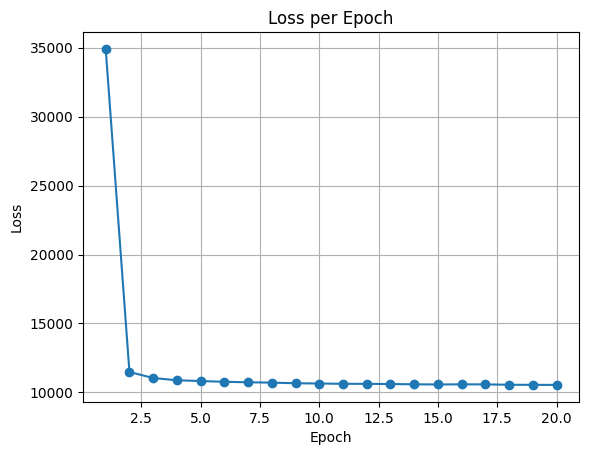

In [ ]:
losses = history.history['loss']
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

# Timestep NN

Define reshape data function for each value of k

In [ ]:
# X_train and X_val should be 3D arrays of shape (samples, k, features)
# y_train and y_val should be 2D arrays of shape (samples, 1)

# reshape input such that each timestep holds the previous k timesteps of input
# note that input X gets last row truncated bc there's no info on next y step
# to train it on, and y gets first k rows truncated bc no previous input to feed
# into it
def reshape_input(X, y, k):
  newY = []
  new_cols = []
  # extend every col except for Time
  for i in range(k):
    new_cols.extend([str(col) + str(i) for col in X.columns])
  result = []
  for i in range(len(X) - k):
    # Check if consecutive time sequences exist
    consecutive = True
    for j in range(1, k):
      if X.iloc[i + j]['Time'] - X.iloc[i + j - 1]['Time'] != 1:
        consecutive = False
        break
    if consecutive:
      row = []
      for j in range(k):
        row.extend(X.iloc[i + j])
      result.append(row)
      # modify y
      newY.append(i + k)

  # modify X to drop Time now that it's no longer needed
  newX = pd.DataFrame(result, columns=new_cols)
  newX = newX.drop(columns=[col for col in newX.columns if 'Time' in col])

  return newX, pd.DataFrame(newY)

In [ ]:
# define arrays to store metrics for each value of k = {5, 10, 100, 500}
ks = [5, 10, 100]
last_training_errors = [0] * 3
test_errors = [0] * 3
train_mapes = [0] * 3
test_mapes = [0] * 3
train_maes = [0] * 3
test_maes = [0] * 3
rs = [0] * 3
losses = [0] * 3


For each value of k, run model and save stats

In [ ]:
from keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

for i in range(5):
  print('k =', ks[i], '-------------------------------------------------')
  reshaped_X, reshaped_y = reshape_input(X, y, ks[i])
  print('X shape:', reshaped_X.shape)
  print('y shape:', reshaped_y.shape)


  # Split data into training and holdout validation sets
  ts_X_train, ts_X_test, ts_y_train, ts_y_test = train_test_split(reshaped_X, reshaped_y,
                                                    test_size=0.3,
                                                    random_state=42)

  # normalize data

  ts_X_train=(ts_X_train-ts_X_train.mean())/ts_X_train.std()
  ts_X_test=(ts_X_test-ts_X_test.mean())/ts_X_test.std()

  ts_X_train.fillna(0, inplace=True)
  ts_X_test.fillna(0, inplace=True)

  print()
  print("Normalized dataset")

  ts_X_train.shape

  # Manually build NN w optimized hyperparams from control NN
  # NOTE: HAVE TO MODIFY NUM OF LAYERS MANUALLY
  # Build the model with the optimal hyperparameters and train it on the data for 500 epochs
  ts_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(NUM_FEATURES * ks[i],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 unit for regression
  ])
  # Compile the model
  optimizer = Adam(learning_rate=0.001)
  ts_model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using Adam optimizer and mean squared error loss for regression

  # Print model summary
  ts_model.summary()

  # Train the model
  summary = ts_model.fit(ts_X_train, ts_y_train, epochs=75, batch_size=32)

  # test model
  ts_y_pred = ts_model.predict(ts_X_test)

  # print training history
  print(summary.history)

  loss = summary.history['loss']
  losses[i] = loss

  # get accuracy metrics
  print('training set error from most recent epoch:', summary.history['loss'][-1])
  print('test set error:', mean_squared_error(ts_y_test, ts_y_pred))

  # Get MAPE
  ts_y_train_pred = ts_model.predict(ts_X_train)
  train_mape = mean_absolute_percentage_error(ts_y_train, ts_y_train_pred) * 100
  train_mapes[i] = train_mape
  test_mape = mean_absolute_percentage_error(ts_y_test, ts_y_pred) * 100
  test_mapes[i] = test_mape
  print("TRAIN Mean Absolute Percentage Error (MAPE):", train_mape)
  print("TEST Mean Absolute Percentage Error (MAPE):", test_mape)

  # Get MAE
  train_mae = mean_absolute_error(ts_y_train, ts_y_train_pred) * 100
  train_maes[i] = train_mae
  test_mae = mean_absolute_error(ts_y_test, ts_y_pred) * 100
  test_maes[i] = test_mae
  print('TRAIN MAE:', train_mae)
  print('TEST MAE:', test_mae)

  # Calculate R-squared
  r_squared = r2_score(ts_y_test, ts_y_pred)
  rs[i] = r_squared

  print("Coefficient of determination (R-squared):", r_squared)


k = 5 -------------------------------------------------
X shape: (82075, 75)
y shape: (82075, 1)

Normalized dataset
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                4864      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17409 (68.00 KB)
Trainable params: 17409 (68.00 KB)
Non

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

See Eval Metrics

In [ ]:
# Create a DataFrame, removing the last value for each metric
ts_eval_metrics = pd.DataFrame({
    'k': ks,  # Assuming 'ks' contains values of k
    'Last Training Error': last_training_errors,
    'Test Error': test_errors,
    'Train MAPE': train_mapes,
    'Test MAPE': test_mapes,
    'Train MAE': train_maes,
    'Test MAE': test_maes,
    'RS': rs
})
print(ts_eval_metrics.to_string(float_format="{:.3f}".format))

Download metrics in spreadsheet format

In [ ]:
ts_eval_metrics.to_excel('pinnevalmetrics2.xlsx', index=True)

Graph loss over epochs

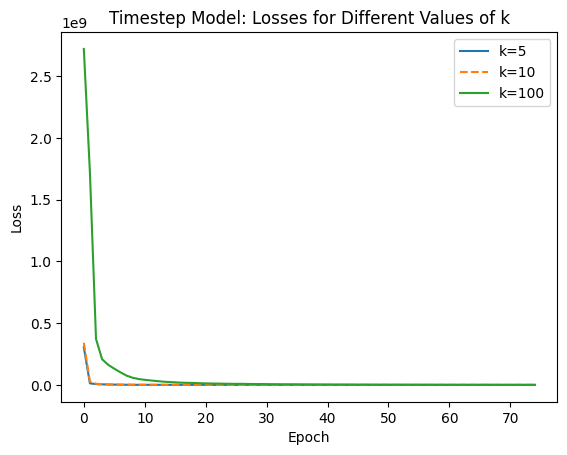

In [ ]:
for i, (loss, k) in enumerate(zip(losses, ks)):
    if k == 10:
        plt.plot(loss, label=f'k={k}', linestyle='--')  # Dash line
    else:
        plt.plot(loss, label=f'k={k}')  # Default line style and color

# Set the title and labels
plt.title('Timestep Model: Losses for Different Values of k')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

# Hybrid PINN-Timestep Model

Save metrics here

In [ ]:
# define arrays to store metrics for each value of k = {5, 10, 100}
ks = [5, 10, 100]

p_last_training_errors = [0] * 3
p_test_errors = [0] * 3
p_train_mapes = [0] * 3
p_test_mapes = [0] * 3
p_train_maes = [0] * 3
p_test_maes = [0] * 3
p_rs = [0] * 3
p_losses = [0] * 3

Run model for each value of k with custom PINN loss function

In [ ]:
from keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

for i in range(5):
  print('k =', ks[i], '-------------------------------------------------')
  reshaped_X, reshaped_y = reshape_input(X, y, ks[i])
  print('X shape:', reshaped_X.shape)
  print('y shape:', reshaped_y.shape)


  # Split data into training and holdout validation sets
  p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(reshaped_X, reshaped_y,
                                                    test_size=0.3,
                                                    random_state=42)

  # normalize data

  p_X_train=(p_X_train-p_X_train.mean())/p_X_train.std()
  p_X_test=(p_X_test-p_X_test.mean())/p_X_test.std()

  # replace nan values with 0 after normalization
  p_X_train.fillna(0, inplace=True)
  p_X_test.fillna(0, inplace=True)

  p_y_train = p_y_train.astype(np.float64)

  # Manually build NN w optimized hyperparams from control NN
  # NOTE: HYPERPARAMS BUILT IN MANUALLY HERE
  # Build the model with the optimal hyperparameters and train it on the data for 20 epochs
  hybrid_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(NUM_FEATURES * ks[i],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 unit for regression
])
  # Compile the model
  optimizer = Adam(learning_rate=0.001)
  hybrid_model.compile(optimizer=optimizer, loss=CustomLoss(p_X_train))

  # Print model summary
  hybrid_model.summary()

  # Train the model
  summary = hybrid_model.fit(p_X_train, p_y_train, epochs=20, batch_size=32)

  # test model
  p_y_pred = hybrid_model.predict(p_X_test)

  # print training history
  print(summary.history)

  loss = summary.history['loss']
  losses[i] = loss

  # get accuracy metrics
  print('training set error from most recent epoch:', summary.history['loss'][-1])
  print('test set error:', mean_squared_error(p_y_test, p_y_pred))

  # Get MAPE
  p_y_train_pred = hybrid_model.predict(p_X_train)
  p_train_mape = mean_absolute_percentage_error(p_y_train, p_y_train_pred) * 100
  p_train_mapes[i] = p_train_mape
  p_test_mape = mean_absolute_percentage_error(p_y_test, p_y_pred) * 100
  p_test_mapes[i] = test_mape
  print("TRAIN Mean Absolute Percentage Error (MAPE):", p_train_mape)
  print("TEST Mean Absolute Percentage Error (MAPE):", p_test_mape)

  # Get MAE
  p_train_mae = mean_absolute_error(p_y_train, p_y_train_pred) * 100
  p_train_maes[i] = p_train_mae
  p_test_mae = mean_absolute_error(p_y_test, p_y_pred) * 100
  p_test_maes[i] = p_test_mae
  print('TRAIN MAE:', p_train_mae)
  print('TEST MAE:', p_test_mae)

  # Calculate R-squared
  p_r_squared = r2_score(p_y_test, p_y_pred)
  p_rs[i] = p_r_squared

  print("Coefficient of determination (R-squared):", p_r_squared)


k = 5 -------------------------------------------------
X shape: (82075, 75)
y shape: (82075, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                4864      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17409 (68.00 KB)
Trainable params: 17409 (68.00 KB)
Non-trainable params: 0

KeyboardInterrupt: 

In [ ]:
p_y_train.shape

Get eval metrics up through k = 100

In [ ]:
# Create a DataFrame, removing the last value for each metric
hybrid_eval_metrics = pd.DataFrame({
    'k': ks,  # Assuming 'ks' contains values of k
    'Train MAPE': p_train_mapes,
    'Test MAPE': p_test_mapes,
    'Train MAE': p_train_maes,
    'Test MAE': p_test_maes,
    'RS': p_rs
})
print(hybrid_eval_metrics.to_string(float_format="{:.3f}".format))

     k  Train MAPE  Test MAPE   Train MAE    Test MAE     RS
0    5     690.028     13.831 3736342.732 3700553.650 -1.439
1   10     561.953     13.831 3421033.271 3402290.844 -1.128
2  100     608.544     13.831 3313923.531 3587035.690 -0.943


Download metrics in spreadsheet format

In [ ]:
hybrid_eval_metrics.to_excel('hybridevalmetrics.xlsx', index=True)

Plot Losses over Epochs

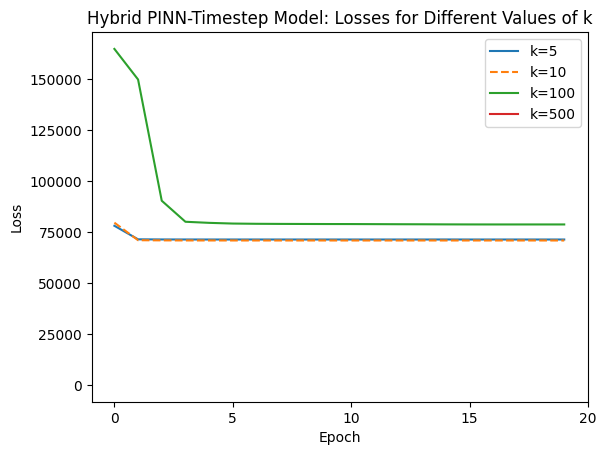

In [ ]:
# plot every loss except k = 500 bc training set for that was empty
for i, (loss, k) in enumerate(zip(losses, ks)):
    if k == 10:
        plt.plot(loss, label=f'k={k}', linestyle='--')  # Dash line
    else:
        plt.plot(loss, label=f'k={k}')  # Default line style and color

# Set the title and labels
plt.title('Hybrid PINN-Timestep Model: Losses for Different Values of k')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.xticks(range(0, 21, 5))

plt.legend()